In [3]:
import os
import pickle
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from lifelines import CoxPHFitter

In [4]:
def plot_loss(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # set the y-axis to logarithmic scale
    plt.yscale('log')
    plt.show()

def barplot_best_loss_per_model(histories):
    best_loss = []
    for history in histories.values():
        best_loss.append(min(history['val_loss']))
    plt.figure(figsize=(15, 10))
    sns.barplot(x=list(histories.keys()), y=best_loss)
    # add the value of the best loss to the bar
    for i, v in enumerate(best_loss):
        plt.text(i, v, str(round(v, 4)), color='black', ha='center')
    plt.title('best loss per model')
    plt.ylabel('best loss')
    plt.xlabel('model')
    plt.show()

In [5]:
# Iterate through all files in results folder
losses = dict()
for file in os.listdir('../results'):
    # Check whether file is in text format or not
    if file.endswith(".pickle"):
        # Create the full input path and read the file
        input_path = os.path.join('../results', file)
        with open(input_path, 'rb') as input_file:
            history = pickle.load(input_file)
        # Add history to dictionary
        model_name = 'model_' + file.split('_')[2] + '_' + file.split('_')[3]
        losses[model_name] = {'loss' : history['loss'], 'val_loss' : history['val_loss']}

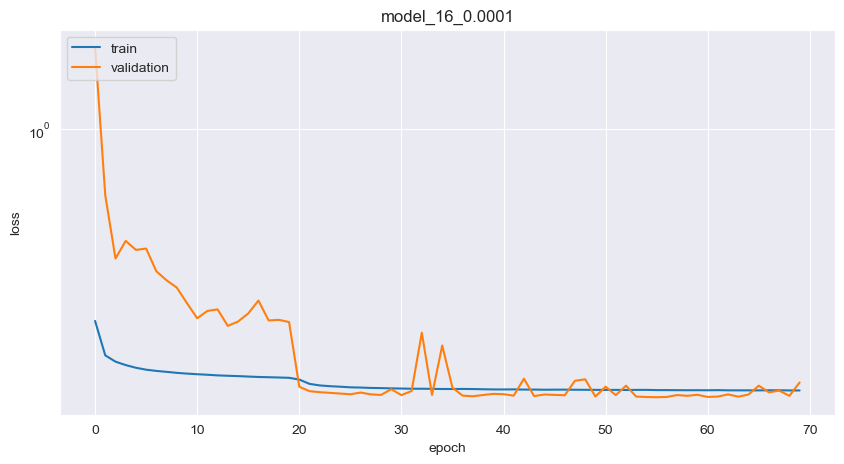

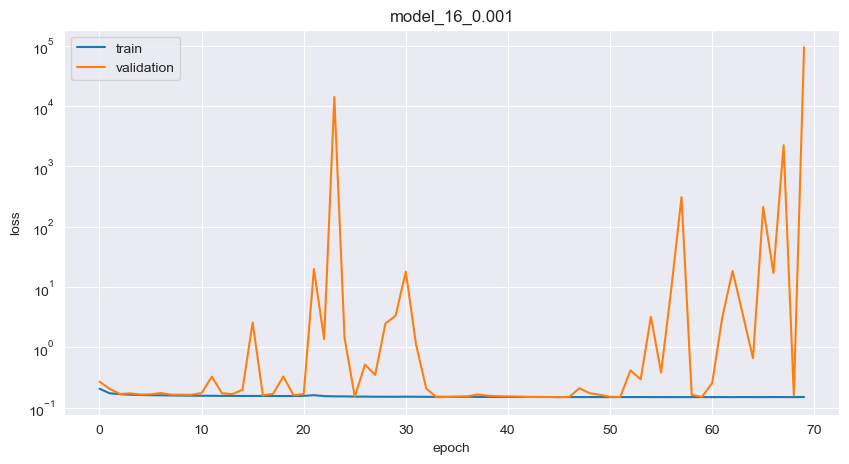

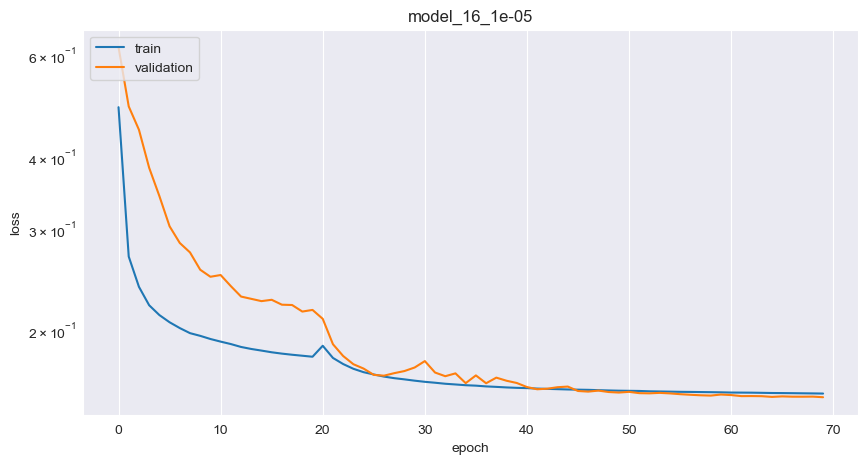

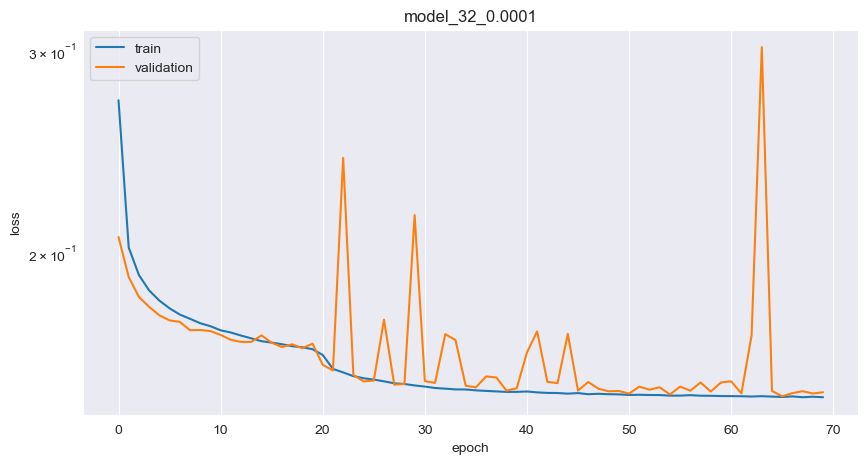

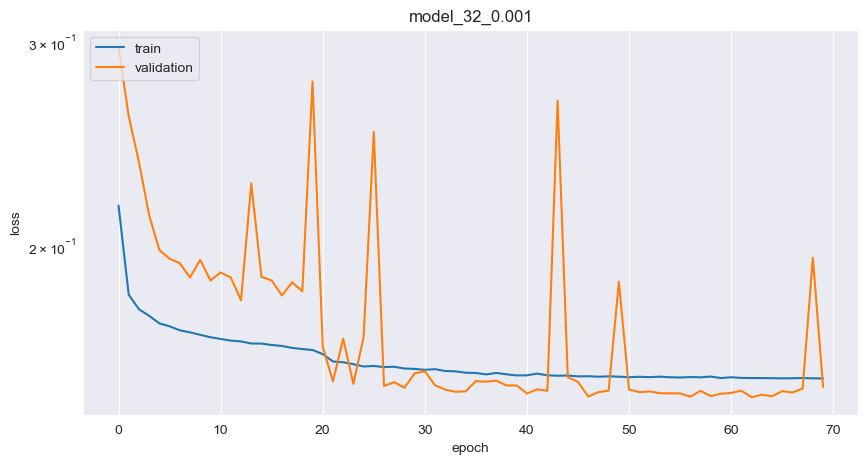

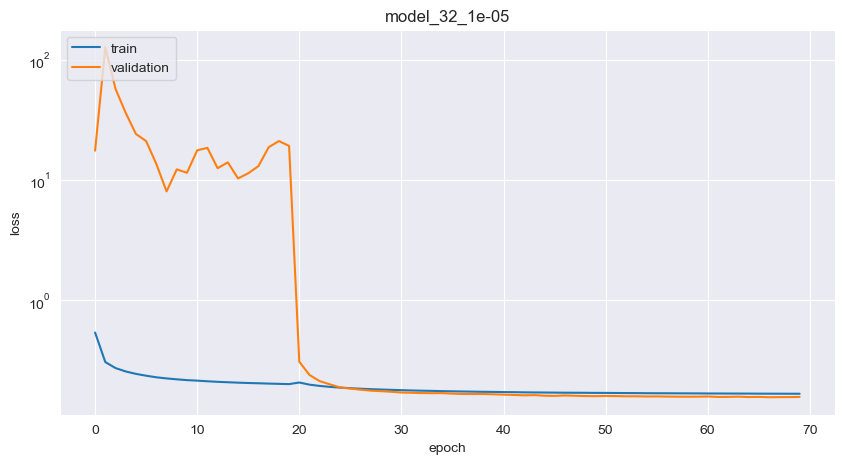

In [6]:
for model in losses:
    plot_loss(losses[model], model)

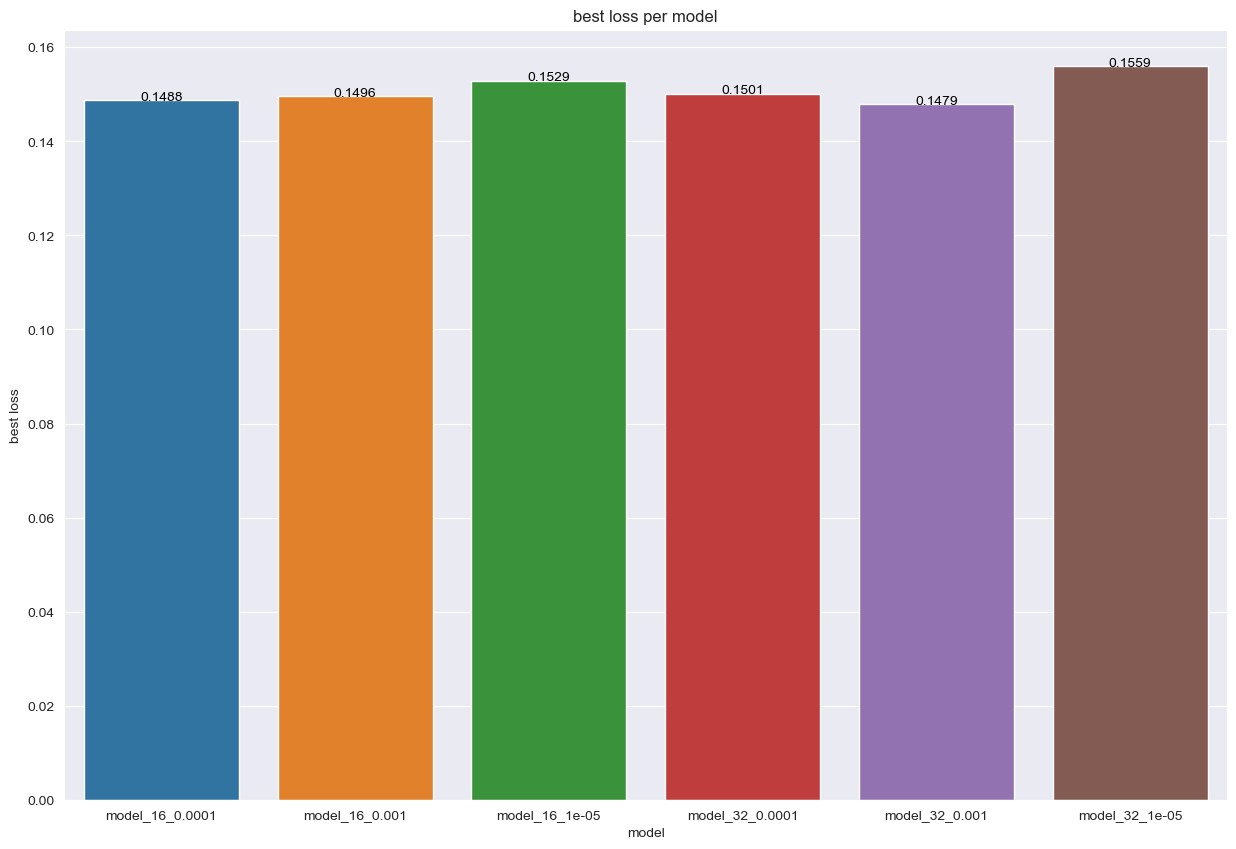

In [7]:
barplot_best_loss_per_model(losses)

In [2]:
# Corrected C-index comparison between models
import sys

sys.path.insert(0, "D:\ISEN\M1\Projet M1\Survival_Rate_Prediction_DLBCL\Scripts")

import KimiaNet_Keras_Feature_Extraction as ke

In [ ]:
# Load models from Models folder
for model in os.listdir('../Models'):
    #input_path = os.path.join('../Models', model, '2')
    input_path = os.path.join('../Models', model)
    ke.extract_features(ke.PATCH_DIR, f'../extracted_features_{model}.pickle', input_path, ke.PATCH_SIZE, ke.BATCH_SIZE,
                     ke.IMG_FORMAT)

In [2]:
# Load extracted features
import pickle
extracted_features = []
for file in os.listdir('..'):
    # Check whether file is in pickle format or not
    if file.split('.')[-1] == 'pickle':
        if len(file.split('_')) < 3:
            continue
        extracted_features.append(f'../{file}')

In [3]:
extracted_features = extracted_features[0:2]

In [4]:
def PCAMethod(df, n_feats):
    new_df = df[last_cols]
    pca = PCA(n_components=n_feats)
    pca.fit(new_df)
    pca_transformed = pca.transform(new_df)
    pca_df = pd.DataFrame(data=pca_transformed, columns=['PC{}'.format(i+1) for i in range(n_feats)])
    final_df = np.hstack((df[first_cols], pca_df))
    final_df= pd.DataFrame(final_df, columns=list(df[first_cols].columns) + list(pca_df.columns))
    return final_df

In [5]:
model = extracted_features[0]
with open(model, 'rb') as f:
        model = pickle.load(f)
model = dict(model)
averaged_features = {}

In [6]:
# keep the median for each patient patches
for patient in model.keys():
    averaged_features.update({patient: np.median(list(model[patient].values()), axis=0)})

In [7]:
# Convert the dictionary to a csv file where each row is a patient and each column is a feature using pandas
features = pd.DataFrame.from_dict(averaged_features, orient='index', dtype=np.float32)
# Change the index data type to int
features.index = features.index.astype(np.int32)
# Merge the extracted features with the clinical data on the patient ID
clinical_data = pd.read_csv('../CSV/clinical_data_with_no_missing_values.csv')
clinical_data = clinical_data.set_index('patient_id')

In [8]:
df = clinical_data.join(features, on='patient_id')

In [9]:
df = df.astype(np.float32)
df.drop(["PFS"], inplace=True, axis=1)
df.rename(columns={"Follow-up Status": "FUS"}, inplace=True)

In [21]:
last_cols = ["C" + str(i) for i in range(df.shape[1]-19)]
first_cols = ['MYC IHC', 'BCL2 IHC', 'BCL6 IHC', 'CD10 IHC', 'MUM1 IHC',
           'HANS', 'BCL6 FISH', 'MYC FISH', 'BCL2 FISH', 'Age', 'ECOG PS', 'LDH',
           'EN', 'Stage', 'IPI Score', 'IPI Risk Group (4 Class)', 'RIPI Risk Group', 'OS', 'FUS']
cols = first_cols + last_cols
df.columns = cols

In [24]:
# Drop all the columns with a variance of 0
df = df.loc[:, (df != df.iloc[0]).any()]
# Apply PCA
df = PCAMethod(df, 128)
# Apply QuantileTransformer
qt = QuantileTransformer(n_quantiles=10, random_state=42)
qt.fit(df)
df = pd.DataFrame.from_records(qt.transform(df), columns=df.columns)
# Fit CoxPH model
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df, duration_col='OS', event_col='FUS', show_progress=True)
c_main = cph.score(df, scoring_method="concordance_index")
print("The C-index is: %.3f" % c_main)

KeyError: "None of [Index(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',\n       ...\n       'C502', 'C503', 'C504', 'C505', 'C506', 'C507', 'C508', 'C509', 'C510',\n       'C511'],\n      dtype='object', length=512)] are in the [columns]"

In [11]:
for model in extracted_features:
    with open(model, 'rb') as f:
        model = pickle.load(f)
    model = dict(model)
    averaged_features = {}

    # keep the median for each patient patches
    for patient in model.keys():
        averaged_features.update({patient: np.median(list(model[patient].values()), axis=0)})

    # Convert the dictionary to a csv file where each row is a patient and each column is a feature using pandas
    df = pd.DataFrame.from_dict(averaged_features, orient='index')

    # Merge the extracted features with the clinical data on the patient ID
    clinical_data = pd.read_csv('../CSV/clinical_data_with_no_missing_values.csv')
    clinical_data = clinical_data.set_index('patient_id')
    df = clinical_data.join(df)

    df = df.astype(np.float32)
    df.drop(["PFS"], inplace=True, axis=1)
    df.rename(columns={"Follow-up Status": "FUS"}, inplace=True)
    last_cols = ["C" + str(i) for i in range(df.shape[1]-19)]
    #last_cols = [str(i) for i in range(df.shape[1]-19)]
    first_cols = ['MYC IHC', 'BCL2 IHC', 'BCL6 IHC', 'CD10 IHC', 'MUM1 IHC',
           'HANS', 'BCL6 FISH', 'MYC FISH', 'BCL2 FISH', 'Age', 'ECOG PS', 'LDH',
           'EN', 'Stage', 'IPI Score', 'IPI Risk Group (4 Class)', 'RIPI Risk Group', 'OS', 'FUS']
    cols = first_cols + last_cols
    df.columns = cols
    # Drop all the columns with a variance of 0
    df = df.loc[:, (df != df.iloc[0]).any()]
    # Apply PCA
    df = PCAMethod(df, 128)
    # Apply QuantileTransformer
    qt = QuantileTransformer(n_quantiles=10, random_state=42)
    qt.fit(df)
    df = pd.DataFrame.from_records(qt.transform(df), columns=df.columns)
    # Fit CoxPH model
    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(df, duration_col='OS', event_col='FUS', show_progress=True)
    c_main = cph.score(df, scoring_method="concordance_index")
    print("The C-index is: %.3f" % c_main)


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values